# Setup

In [33]:
import os
import pickle
import sys

sys.path.append('..')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

from utils import preprocess_data, get_zero_nonzero_datasets

In [4]:
# Read in saved models
model_base_path = '/Users/emiliolr/Google Drive/My Drive/LIFE/hunting_analysis/final_models'
models = {'rf' : {'fp': 'rf_hurdle_10.0mins.pkl'},
          'xgboost' : {'fp' : 'xgboost_hurdle_10.0mins.pkl'},
          'pymer' : {'fp' : 'pymer_hurdle.pkl'}}

for m in models.values():
    model_fp = os.path.join(model_base_path, m['fp'])
    
    with open(model_fp, 'rb') as f:
        model = pickle.load(f)

    m['model'] = model

# Linear model

In [20]:
# Getting fitted coefficients for the 
linear_hurdle = models['pymer']['model']

nonzero_coefs = linear_hurdle.nonzero_model.model.coefs
nonzero_coefs['variable'] = nonzero_coefs.index
nonzero_coefs = nonzero_coefs.sort_values('Estimate')

zero_coefs = linear_hurdle.zero_model.model.coefs
zero_coefs['variable'] = zero_coefs.index
zero_coefs = zero_coefs.sort_values('Estimate')

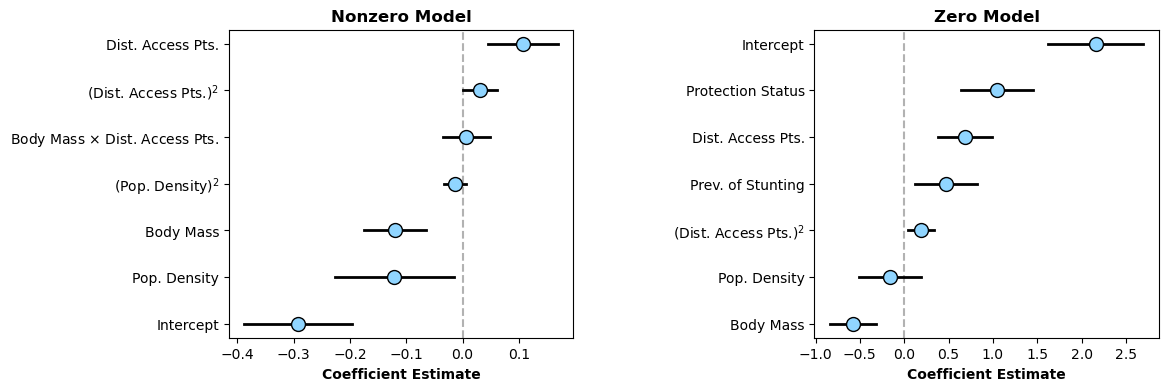

In [61]:
# Plotting model coefficients
#  changing the names for plotting purposes
plot_names = {'Dist_Settlement_KM' : 'Dist. Access Pts.',
              'Body_Mass:Dist_Settlement_KM' : 'Body Mass $\\times$ Dist. Access Pts.',
              'I(Dist_Settlement_KM^2)' : '(Dist. Access Pts.)$^2$',
              'Population_Density' : 'Pop. Density',
              'I(Population_Density^2)' : '(Pop. Density)$^2$', 
              '(Intercept)' : 'Intercept',
              'Body_Mass' : 'Body Mass',
              'Stunting_Pct' : 'Prev. of Stunting',
              'Protected_Area' : 'Protection Status'}

#  plotting
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

for data, model, ax in zip([nonzero_coefs, zero_coefs], ['nonzero', 'zero'], axs):
    ax.scatter(data['Estimate'], data['variable'].replace(plot_names), s = 100, edgecolor = 'black', 
               color = '#90d5ff', zorder = 100)
    for row in data.iterrows():
        row = row[1]
        name = plot_names[row['variable']]
        ax.plot([row['2.5_ci'], row['97.5_ci']], [name, name], color = 'black', 
                linewidth = 2, zorder = 20)
    
    ax.axvline(0, linestyle = '--', color = 'grey', zorder = 0, alpha = 0.6)

    ax.set_title(f'{model} model'.title(), weight = 'bold')
    ax.set_xlabel('Coefficient Estimate', weight = 'bold')

fig.subplots_adjust(wspace = 0.7)

plt.savefig('/Users/emiliolr/Desktop/linear_hurdle_coefficients.png', bbox_inches = 'tight', dpi = 400)
plt.show()

# Random forest

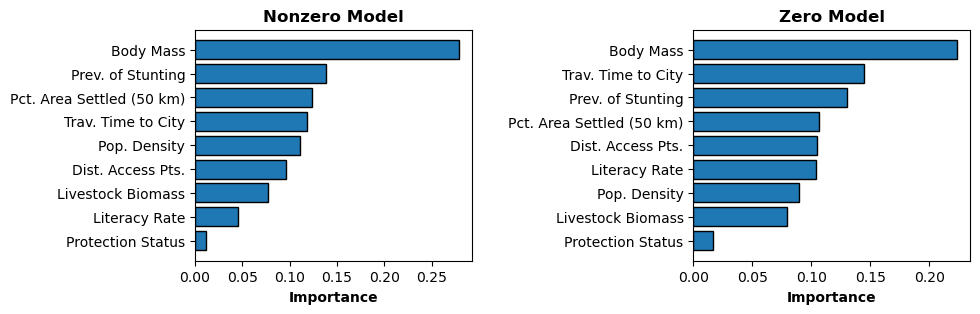

In [63]:
# Plotting random forest feature importances
rf_hurdle = models['rf']['model']
sub_models = {'nonzero' : rf_hurdle.nonzero_model, 'zero' : rf_hurdle.zero_model}

#  names of vars for plotting
plot_names = {'Dist_Settlement_KM' : 'Dist. Access Pts.',
              'Population_Density' : 'Pop. Density',
              'Body_Mass' : 'Body Mass',
              'Stunting_Pct' : 'Prev. of Stunting',
              'Protected_Area' : 'Protection Status',
              'Literacy_Rate' : 'Literacy Rate',
              'Travel_Time_Large' : 'Trav. Time to City',
              'Livestock_Biomass' : 'Livestock Biomass',
              'Percent_Settlement_50km' : 'Pct. Area Settled (50 km)'}

fig, axs = plt.subplots(1, 2, figsize = (10, 3), sharey = False)

for i, model_name in enumerate(sub_models.keys()):
    ax = axs[i]
    
    model = sub_models[model_name]
    # model.model.estimator.importance_type = 'gain'

    imp = model.feature_importances_
    feat = model.feature_names_in_
    feat = [plot_names[f] for f in feat]

    #  sorting by feature importance score
    feat_imp_df = pd.DataFrame({'feature' : feat, 'importance' : imp})
    feat_imp_df = feat_imp_df.sort_values('importance')
    
    ax.barh(feat_imp_df['feature'], feat_imp_df['importance'], edgecolor = 'black')
    ax.set_title(f'{model_name} model'.title(), weight = 'bold')
    ax.set_xlabel('Importance', weight = 'bold')

fig.subplots_adjust(wspace = 0.8)

plt.savefig('/Users/emiliolr/Desktop/feature_importances_rf.png', bbox_inches = 'tight', dpi = 400)
plt.show()

# Partial dependence plots for ML methods

In [31]:
# Picking out a model
model_to_use = 'rf'

model = models[model_to_use]['model']
nonzero_model, zero_model = model.nonzero_model, model.zero_model

In [34]:
# Read in the recreated mammal dataset - needed for PDPs!
data_fp = '/Users/emiliolr/Google Drive/My Drive/LIFE/datasets/derived_datasets/benitez_lopez2019_recreated/benitez_lopez2019_recreated_w_original.csv'
data = pd.read_csv(data_fp)

#  applying necessary preprocessing to match what was done during final model training
pp_args = {'include_indicators' : False,
           'include_categorical' : False,
           'polynomial_features' : 0,
           'log_trans_cont' : False,
           'dataset' : 'mammals_recreated',
           'embeddings_to_use' : None,
           'embeddings_args' : None}

pp_data = preprocess_data(data, standardize = True, **pp_args)
pp_data = pp_data.drop(columns = ['Response_Ratio'])

#  getting zero/nonzero datasets
X_zero, X_nonzero = get_zero_nonzero_datasets(pp_data, extirp_pos = model.extirp_pos, pred = True, **model.data_args)

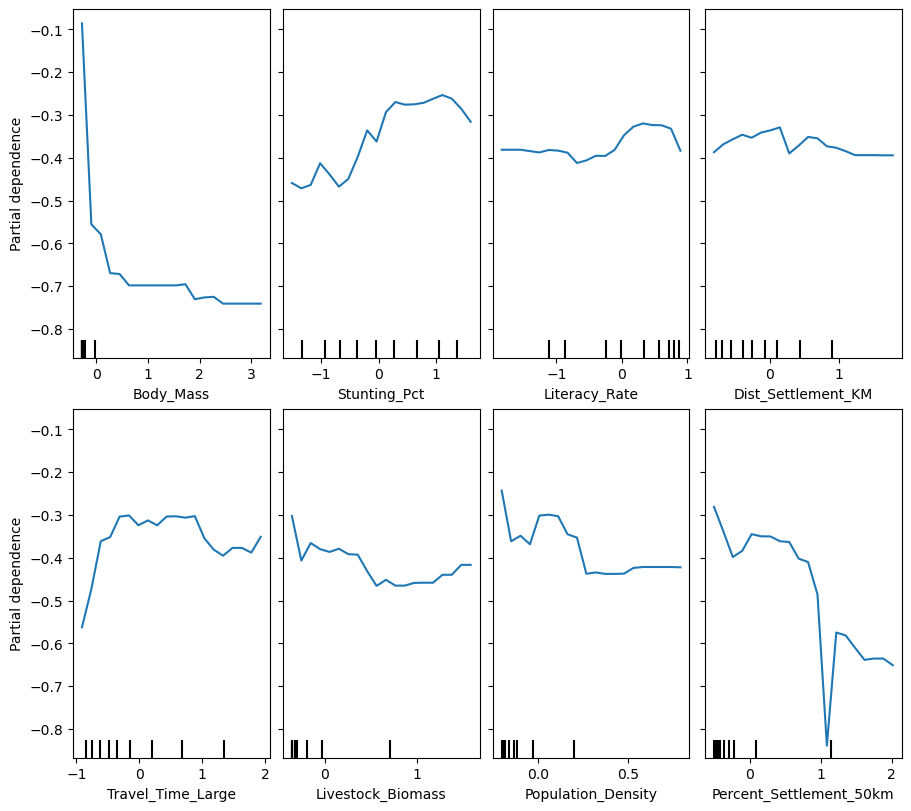

In [46]:
# Code modified from sklearn docs: https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#sphx-glr-auto-examples-inspection-plot-partial-dependence-py
#  - FIRST TRYING ON ONLY NONZERO MODEL!
common_params = {
    'subsample' : 50,
    'n_jobs' : 1,
    'grid_resolution' : 20,
    'random_state' : 1693,
}

features_info = {
    'features' : [c for c in pp_data.columns if c != 'Protected_Area'],
    'kind' : 'average'
}

_, ax = plt.subplots(ncols = 4, nrows = 2, figsize = (9, 8), constrained_layout = True)
display = PartialDependenceDisplay.from_estimator(nonzero_model, X_nonzero, **features_info,
                                                  ax = ax, **common_params)